In [1]:
import os
import random
import numpy as np
import pandas as pd
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
%pip install wordcloud


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Config

In [2]:
DATA_PATH = "train_absa.csv"
MODEL_NAME = "microsoft/deberta-v3-base"
MAX_LENGTH = 256
RANDOM_SEED = 42

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(RANDOM_SEED)

# Load Data

In [6]:
df = pd.read_csv(DATA_PATH)
df = df.sample(frac=1.0, random_state=RANDOM_SEED).reset_index(drop=True)
df = df[df["sentiment"].isin(["positive", "negative", "neutral"])].reset_index(drop=True)

# Label mapping
labels = sorted(df["sentiment"].unique())
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}
df["label"] = df["sentiment"].map(label2id)

# Split
train, val = train_test_split(
    df,
    test_size=0.1,
    stratify=df["label"],
    random_state=RANDOM_SEED,
)

print("Train:", len(train), "Val:", len(val))

Train: 3927 Val: 437


In [7]:
train_ds = Dataset.from_pandas(train[["id","text","aspect","label"]])
val_ds   = Dataset.from_pandas(val[["id","text","aspect","label"]])

dataset = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
})

In [8]:
train["sentiment"].value_counts()

sentiment
positive    1918
negative    1324
neutral      685
Name: count, dtype: int64

# EDA

In [9]:
print("Jumlah baris:", len(df))
print("\nInfo dataframe:")
print(df.info())

print("\nCek missing values:")
print(df.isnull().sum())

Jumlah baris: 4364

Info dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4364 entries, 0 to 4363
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         4364 non-null   object
 1   text       4364 non-null   object
 2   aspect     4364 non-null   object
 3   sentiment  4364 non-null   object
 4   label      4364 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 170.6+ KB
None

Cek missing values:
id           0
text         0
aspect       0
sentiment    0
label        0
dtype: int64


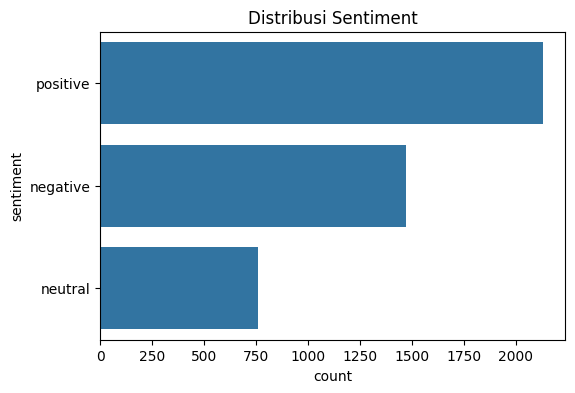

sentiment
positive    2131
negative    1472
neutral      761
Name: count, dtype: int64

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(y=df['sentiment'], order=df['sentiment'].value_counts().index)
plt.title("Distribusi Sentiment")
plt.show()

df['sentiment'].value_counts()


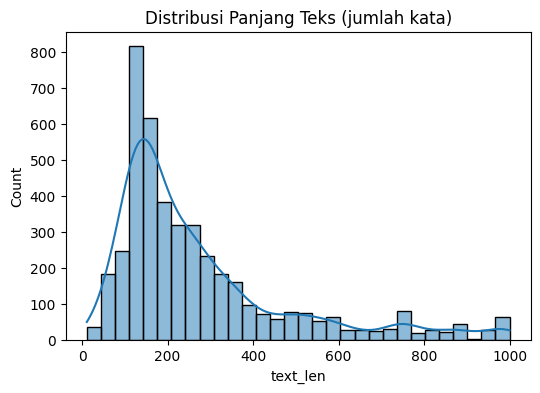

count    4364.000000
mean      273.953254
std       209.133029
min        11.000000
25%       135.000000
50%       199.000000
75%       331.000000
max      1000.000000
Name: text_len, dtype: float64

In [11]:
df['text_len'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6,4))
sns.histplot(df['text_len'], bins=30, kde=True)
plt.title("Distribusi Panjang Teks (jumlah kata)")
plt.show()

df['text_len'].describe()

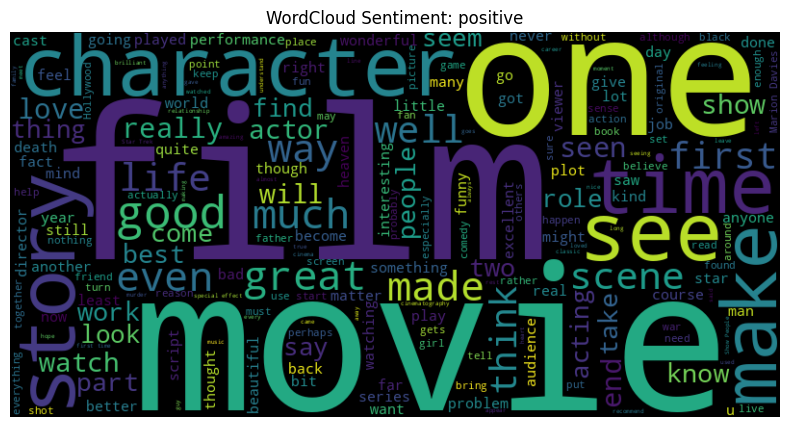

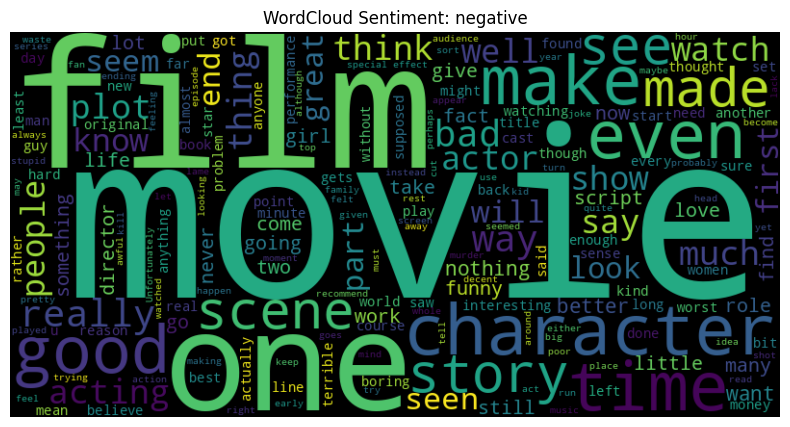

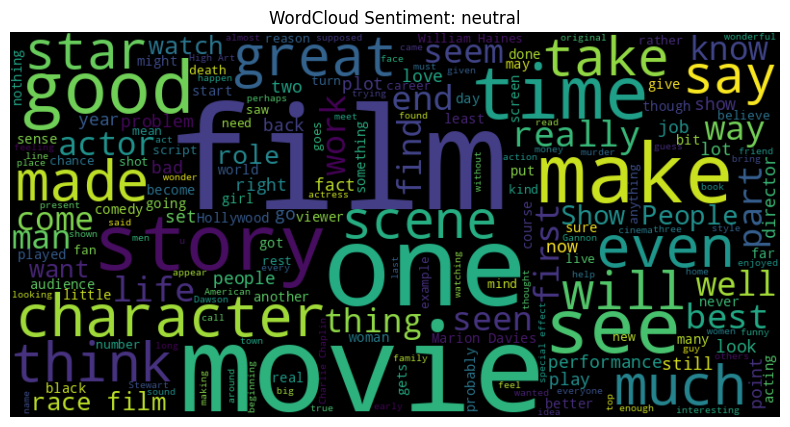

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(sentiment):
    text = " ".join(df[df['sentiment']==sentiment]['text'])
    wc = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud Sentiment: {sentiment}")
    plt.show()

show_wordcloud("positive")
show_wordcloud("negative")
show_wordcloud("neutral")


# Tokenizer

In [15]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess(example):
    result = tokenizer(
        example["aspect"],
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )
    result["labels"] = example["label"]
    return result

encoded_ds = dataset.map(preprocess, batched=True, remove_columns=["id","text","aspect","__index_level_0__"])


/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Map: 100%|██████████| 437/437 [00:00<00:00, 3752.37 examples/s]


# Model

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
args = TrainingArguments(
    output_dir="deberta_absa_model",
    overwrite_output_dir=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,

    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    num_train_epochs=7,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    fp16=True,
    report_to="none"
)

In [18]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipykernel_6043/2935922312.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.797700,0.670801,0.727689,0.603164
2,0.588500,0.582265,0.773455,0.722437
3,0.427400,0.490068,0.814645,0.779075
4,0.304400,0.611827,0.803204,0.763955
5,0.198900,0.644726,0.819222,0.794654
6,0.142200,0.764838,0.816934,0.796192
7,0.111500,0.821522,0.807780,0.783939


TrainOutput(global_step=1722, training_loss=0.3981668554531988, metrics={'train_runtime': 328.0247, 'train_samples_per_second': 83.802, 'train_steps_per_second': 5.25, 'total_flos': 3616427224650240.0, 'train_loss': 0.3981668554531988, 'epoch': 7.0})

In [19]:
print("===== Evaluation on validation set =====")
val_metrics = trainer.evaluate(encoded_ds["validation"])
for k, v in val_metrics.items():
    print(f"{k}: {v:.4f}")

===== Evaluation on validation set =====


eval_loss: 0.7648
eval_accuracy: 0.8169
eval_f1_macro: 0.7962
eval_runtime: 1.2492
eval_samples_per_second: 349.8140
eval_steps_per_second: 11.2070
epoch: 7.0000


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import textwrap

def plot_confusion_matrix(trainer, eval_dataset, id2label):
    preds_output = trainer.predict(eval_dataset)
    preds = np.argmax(preds_output.predictions, axis=1)
    labels_np = preds_output.label_ids

    cm = confusion_matrix(labels_np, preds)
    label_names = [id2label[i] for i in range(len(id2label))]

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation="nearest")  # gunakan colormap default
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(label_names))
    plt.xticks(tick_marks, label_names, rotation=45, ha="right")
    plt.yticks(tick_marks, label_names)

    # Tulis angka di tiap kotak
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

def show_classification_report(trainer, eval_dataset, id2label):
    preds_output = trainer.predict(eval_dataset)

    preds = np.argmax(preds_output.predictions, axis=1)
    labels_np = preds_output.label_ids

    target_names = [id2label[i] for i in range(len(id2label))]

    print("\n=== Classification Report ===")
    print(classification_report(labels_np, preds, target_names=target_names, digits=4))

from collections import Counter

def show_label_distributions(trainer, eval_dataset, id2label):
    preds_output = trainer.predict(eval_dataset)

    preds = np.argmax(preds_output.predictions, axis=1)
    labels_np = preds_output.label_ids

    true_counts = Counter(labels_np)
    pred_counts = Counter(preds)

    print("\n=== Label Distribution (True vs Pred) ===")
    print("index -> label_name | true_count | pred_count")
    for i in range(len(id2label)):
        label_name = id2label[i]
        t = true_counts.get(i, 0)
        p = pred_counts.get(i, 0)
        print(f"{i} -> {label_name:>10} | true={t:4d} | pred={p:4d}")

def show_error_examples(trainer, eval_dataset, val_df, id2label, max_examples=10):
    preds_output = trainer.predict(eval_dataset)

    preds = np.argmax(preds_output.predictions, axis=1)
    labels_np = preds_output.label_ids

    wrong_idx = np.where(preds != labels_np)[0]

    print(f"\n=== Error Analysis ===")
    print(f"Total validation samples : {len(labels_np)}")
    print(f"Total misclassified      : {len(wrong_idx)} "
          f"({len(wrong_idx)/len(labels_np):.2%})")
    print(f"Showing up to {max_examples} examples:\n")

    for idx in wrong_idx[:max_examples]:
        row = val_df.iloc[idx]
        true_label = id2label[int(labels_np[idx])]
        pred_label = id2label[int(preds[idx])]
        print("-" * 80)
        print(f"ID      : {row['id']}")
        print(f"ASPECT  : {row['aspect']}")
        print(f"TRUE    : {true_label}")
        print(f"PRED    : {pred_label}")
        print("TEXT    :")
        print(row["text"])
        print()


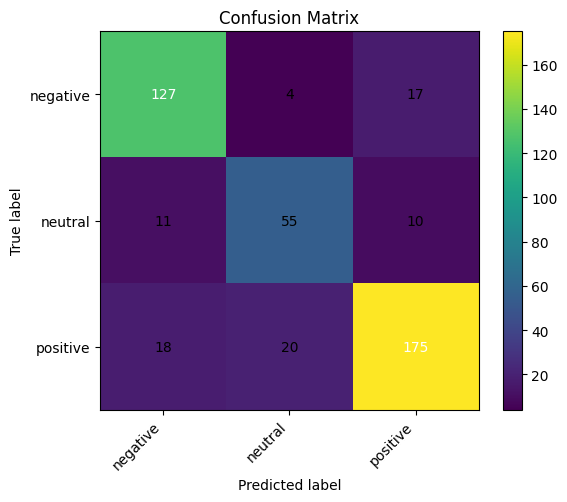

In [21]:
plot_confusion_matrix(trainer, encoded_ds["validation"], id2label)

In [22]:
show_classification_report(trainer, encoded_ds["validation"], id2label)


=== Classification Report ===
              precision    recall  f1-score   support

    negative     0.8141    0.8581    0.8355       148
     neutral     0.6962    0.7237    0.7097        76
    positive     0.8663    0.8216    0.8434       213

    accuracy                         0.8169       437
   macro avg     0.7922    0.8011    0.7962       437
weighted avg     0.8191    0.8169    0.8175       437



In [23]:
show_label_distributions(trainer, encoded_ds["validation"], id2label)


=== Label Distribution (True vs Pred) ===
index -> label_name | true_count | pred_count
0 ->   negative | true= 148 | pred= 156
1 ->    neutral | true=  76 | pred=  79
2 ->   positive | true= 213 | pred= 202


In [24]:
show_error_examples(trainer, encoded_ds["validation"], val, id2label, max_examples=10)


=== Error Analysis ===
Total validation samples : 437
Total misclassified      : 80 (18.31%)
Showing up to 10 examples:

--------------------------------------------------------------------------------
ID      : pos_563
ASPECT  : john mcintire
TRUE    : positive
PRED    : negative
TEXT    :
The penultimate collaboration between director Anthony Mann and star James Stewart (excluding the few days Mann worked on Night Passage before parting company with the star under less than amicable circumstances), The Far Country belies its mainstream look to offer another portrait of an embittered man dragged unwillingly to his own redemption, fighting it every step of the way. This time he's a cattle driver whose response to labour problems - challenging troublesome cowhands to a gunfight at the end of the trail - results in his cattle being confiscated by John McIntire's larcenous judge of the Roy Bean school of law and order. Stealing them back and taking them across the Canadian border, he soo

In [25]:
save_path = "../../model/absa/deberta_absa_saved"
trainer.model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print("Model disimpan di:", save_path)

Model disimpan di: ../../model/absa/deberta_absa_saved


In [ ]:
test_df = pd.read_csv("absa_test.csv")

test_df["label"] = test_df["sentiment"].map(label2id)

test_ds = Dataset.from_pandas(test_df[["id", "text", "aspect", "label"]])

def preprocess_test(example):
    result = tokenizer(
        example["aspect"],
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )
    result["labels"] = example["label"]
    return result

encoded_test_ds = test_ds.map(preprocess_test, batched=True, remove_columns=["id", "text", "aspect"])

print("===== Test Set Evaluation =====")
show_classification_report(trainer, encoded_test_ds, id2label)

Map: 100%|██████████| 202/202 [00:00<00:00, 1841.27 examples/s]


===== Test Set Evaluation =====



=== Classification Report ===
              precision    recall  f1-score   support

    negative     0.7826    0.9000    0.8372        60
     neutral     0.4667    0.3889    0.4242        18
    positive     0.9322    0.8871    0.9091       124

    accuracy                         0.8465       202
   macro avg     0.7272    0.7253    0.7235       202
weighted avg     0.8463    0.8465    0.8445       202

